In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.notebook_repr_html', True)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# reading dataset
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/identify the sentiment/train_2kmZucJ.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/identify the sentiment/test_oJQbWVk.csv')
# concatenating both datasets
df = pd.concat([train, test])
df.head()

,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...


In [ ]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [ ]:
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [ ]:
# checking for shape
print(train.shape, test.shape, df.shape)

(7920, 3) (1953, 2) (9873, 3)


In [ ]:
df.describe()

,id,label
count,9873.000000,7920.000000
mean,4937.000000,0.255808
std,2850.233938,0.436342
min,1.000000,0.000000
25%,2469.000000,0.000000
50%,4937.000000,0.000000
75%,7405.000000,1.000000
max,9873.000000,1.000000


In [ ]:
# checking dtypes
df.dtypes

id         int64
label    float64
tweet     object
dtype: object

In [ ]:
df.isnull().sum()

id          0
label    1953
tweet       0
dtype: int64

### ** EDA and Feature Generation**

In [ ]:
# Checking unique labels
df['label'].value_counts()

0.0    5894
1.0    2026
Name: label, dtype: int64

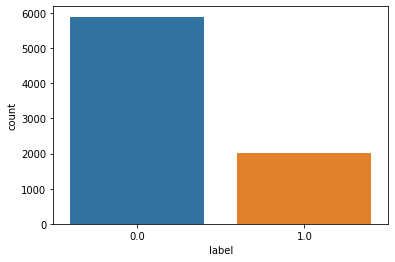

In [ ]:
# Ploting unique labels
sns.countplot(x='label', data=df)

In [ ]:
# Cleaning Raw tweets
def clean_text(text):

    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])

    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)

    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #Convert to lowercase to maintain consistency
    text = text.lower()

    #remove double spaces
    text = re.sub('\s+', ' ',text)

    return text

df["clean_tweet"] = df.tweet.apply(lambda x: clean_text(x))

In [ ]:
#defining stop words
STOP_WORDS = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'also', 'am', 'an', 'and',
              'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
              'between', 'both', 'but', 'by', 'can', "can't", 'cannot', 'com', 'could', "couldn't", 'did',
              "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'else', 'ever',
              'few', 'for', 'from', 'further', 'get', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having',
              'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how',
              "how's", 'however', 'http', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it',
              "it's", 'its', 'itself', 'just', 'k', "let's", 'like', 'me', 'more', 'most', "mustn't", 'my', 'myself',
              'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'otherwise', 'ought', 'our', 'ours',
              'ourselves', 'out', 'over', 'own', 'r', 'same', 'shall', "shan't", 'she', "she'd", "she'll", "she's",
              'should', "shouldn't", 'since', 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs',
              'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're",
              "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't",
              'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where',
              "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', "wouldn't",
              'www', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
# Remove stopwords from all the tweets
df['cleaned_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

In [ ]:
#Adding New feature length of Tweet
df['word_count']=df.cleaned_tweet.str.split().apply(lambda x: len(x))

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
#Adding New Feature Polarity Score
sid= SentimentIntensityAnalyzer()
sid.polarity_scores(df.iloc[0]['cleaned_tweet'])
df['scores'] =df['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
df['compound'] =df['scores'].apply(lambda d:d['compound'])
df['comp_score'] = df['compound'].apply(lambda score: '0' if score>=0 else '1')

In [ ]:
# Remove unnecessary
ndf=df.copy()
ndf = ndf.drop(['tweet','clean_tweet','scores','compound','word_count','comp_score'], axis = 1)

In [ ]:
ndf.head()

,id,label,cleaned_tweet
0,1,0.0,fingerprint pregnancy test android apps beauti...
1,2,0.0,finally transparant silicon case thanks uncle ...
2,3,0.0,love go talk makememories unplug relax iphone ...
3,4,0.0,wired know george made way iphone cute daventr...
4,5,1.0,amazing service apple even talk question unles...


In [ ]:
# Seperating Train and Test Set
train = ndf[~ndf.label.isnull()]
test = ndf[ndf.label.isnull()]

In [ ]:
# Shape
print(train.shape,test.shape)

(7920, 3) (1953, 3)


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
tweets = train['cleaned_tweet'].values
labels = train['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [ ]:
tweets

array(['fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone',
       'finally transparant silicon case thanks uncle yay sony xperia s sonyexperias',
       'love go talk makememories unplug relax iphone smartphone wifi connect',
       ...,
       "helping lovely year old neighbor ipad morning made realise 'i' actually need pad",
       'finally got smart pocket wifi stay connected anytime anywhere ipad samsung s gadget',
       'apple barcelona apple store bcn barcelona travel iphone selfie fly fun cabincrew'],
      dtype=object)

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(tweets, encoded_labels, stratify = encoded_labels)

In [ ]:
train_sentences

array(['coffee cooking mum thankful making glutenfree apple chutneypic twitter y dkmzphbj',
       'super green drink almonddream banana apple flax avocadoe gingerroot kale pic twitter cm sb q p',
       'working hard pays new baby laptop new samsung google chrome hard work',
       ...,
       'good news expo mcgi org nice daisuketakahashi good ps ps game gamer playstation one go photooftheday fun kill shot shotgun sony follow follow follow done code fortnite fortaleza dubai uaepic twitter l zhoh foj',
       'careful pay attention aware surroundings iphone android lol instagood',
       'listening new magnacarta waiting samsung fix download dancing'],
      dtype=object)

In [ ]:
 test_sentences

array(['itunes tries load music every usb drive plug refuses sync actual ipod',
       'one newest models iphone iphoneography tumblr tweegram instagramaddict life thingsilove',
       'soon baby soon mine iloveit tv samsungtv samsung soon mi casa',
       ..., 'third time today charge phone iphone',
       'best birthday present playstation ps sony gift bday thx gracias',
       'green screen setup video photooftheday beautiful producer live fashion videoproduction cute follow commercial iphone apple actor actress iphonesia hollywood losangeles picoftheday movies acting startup startupvideos shotoniphone thinkenpic twitter cqcd pumxz'],
      dtype=object)

In [ ]:
test

,id,label,cleaned_tweet
0,7921,NaN,hate new iphone upgrade let download apps ugh ...
1,7922,NaN,currently shitting fucking pants apple imac ca...
2,7923,NaN,puts cd roms ipad possible ' yes block screen
3,7924,NaN,ipod officially dead lost pictures videos d so...
4,7925,NaN,fighting itunes night want music paid
...,...,...,...
1948,9869,NaN,samsunggalaxynote explodes burns year old than...
1949,9870,NaN,now available hoodie check iphone case music d...
1950,9871,NaN,goes crack right across screen actually provid...
1951,9872,NaN,said adobe big time may well include apple


In [ ]:
test_main=test["cleaned_tweet"].values
test_main

array(['hate new iphone upgrade let download apps ugh apple sucks',
       'currently shitting fucking pants apple imac cashmoney raddest swagswagswag',
       "puts cd roms ipad possible ' yes block screen", ...,
       'goes crack right across screen actually provide durable screen great apple iphone',
       'said adobe big time may well include apple',
       'finally got thanx father samsung galaxy s gift father phone new'],
      dtype=object)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 3000
embedding_dim = 100
max_length = 40


#tokenize sentences

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#converting cdatasets into sequences and pad sequences

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences,maxlen = max_length)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,maxlen = max_length)



In [ ]:
import keras
from keras.layers import Dense,LSTM,Dropout

In [ ]:
model = keras.Sequential([
            keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
            keras.layers.Bidirectional(keras.layers.LSTM(64)),
             keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_padded, train_labels, epochs=10, verbose=1)

Epoch 1/10
186/186 [==============================] - 14s 56ms/step - loss: 0.3737 - accuracy: 0.8303
Epoch 2/10
186/186 [==============================] - 10s 54ms/step - loss: 0.1981 - accuracy: 0.9184
Epoch 3/10
186/186 [==============================] - 10s 55ms/step - loss: 0.1490 - accuracy: 0.9426
Epoch 4/10
186/186 [==============================] - 10s 54ms/step - loss: 0.1119 - accuracy: 0.9614
Epoch 5/10
186/186 [==============================] - 10s 54ms/step - loss: 0.0845 - accuracy: 0.9719
Epoch 6/10
186/186 [==============================] - 10s 54ms/step - loss: 0.0629 - accuracy: 0.9811
Epoch 7/10
186/186 [==============================] - 10s 54ms/step - loss: 0.0468 - accuracy: 0.9860
Epoch 8/10
186/186 [==============================] - 10s 54ms/step - loss: 0.0314 - accuracy: 0.9909
Epoch 9/10
186/186 [==============================] - 10s 55ms/step - loss: 0.0222 - accuracy: 0.9939
Epoch 10/10
186/186 [==============================] - 10s 55ms/step - loss: 0.019

In [ ]:
test_padded

array([[   0,    0,    0, ...,  423, 2006,   46],
       [   0,    0,    0, ..., 2225,  279,   13],
       [   0,    0,    0, ...,    3,  368, 1037],
       ...,
       [   0,    0,    0, ...,  311,    6,    1],
       [   0,    0,    0, ...,   80,  799, 1230],
       [   0,    0,    0, ..., 1125,  705,    5]], dtype=int32)

In [ ]:
prediction7 = model.predict(test_padded)
pred_labels4 = []
for i in prediction7:
    if i >= 0.5:
        pred_labels4.append(1)
    else:
        pred_labels4.append(0)

In [ ]:
len(pred_labels4)

1980

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

Accuracy of prediction on test set :  0.8535353535353535


In [ ]:
vocab_size = 3000
embedding_dim = 100
max_length = 40


#tokenize sentences

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(test_main)
word_index = tokenizer.word_index

#converting cdatasets into sequences and pad sequences

test_main = tokenizer.texts_to_sequences(test_main)
test2 = pad_sequences(test_main,maxlen = max_length)

In [ ]:
len(test2)

1953

In [ ]:
prediction29 = model.predict(test2)
pred_labels5 = []
for i in prediction29:
   if i >= 0.5:
        pred_labels5.append(1)
   else:
        pred_labels5.append(0)

In [ ]:
len(prediction29)


1953

In [ ]:
len(pred_labels5)

1953

In [ ]:
submission = ({
    "label": pred_labels5,
    "id": test['id']})

In [ ]:
submission = pd.read_csv("/content/sample_submission_LnhVWA4.csv")

In [ ]:
submission['label'] = pred_labels5
submission['id']  = test['id']

In [ ]:
pd.DataFrame(submission, columns=['label', 'id']).to_csv("sentiment.csv")

In [ ]:
pred_labels5

[1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
